In [2]:
%cd ~/github/agn_lf/
import source.astro_functions as af
import source.table_functions as tf
import source.lf_xi2 as xi2
import source.vmax as vmax
import source.utils as utils
import source.selection_criteria as sc
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.table as table
import astropy.units as u

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/Users/runburg/github/agn_lf


This is data from the HELP catalogs in the XMMLSS field. The full data file is huge so I use TOPCAT to pare down the data to what we need: redshifts + errors, flux data in NIR (IRAC 1-4) and also the MIPS 24.0 micron flux. N.B.: I think these are actually flux densities so we will need to account for that later.

In [3]:
xmmlss = fits.open('./data/master_cat_irac3_mips24', memmap=True)

In [4]:
# xmmlss[1].header

In [5]:
catalog = table.Table.read('./data/master_cat_irac3_mips24')
print(len(catalog))
catalog[0]

30271


help_id_1,field,ra_1,dec_1,hp_idx,ebv,redshift,zspec,f_irac_i1,ferr_irac_i1,f_ap_irac_i1,ferr_ap_irac_i1,m_irac_i1,merr_irac_i1,m_ap_irac_i1,merr_ap_irac_i1,flag_irac_i1,f_irac_i2,ferr_irac_i2,f_ap_irac_i2,ferr_ap_irac_i2,m_irac_i2,merr_irac_i2,m_ap_irac_i2,merr_ap_irac_i2,flag_irac_i2,f_irac_i3,ferr_irac_i3,f_ap_irac_i3,ferr_ap_irac_i3,m_irac_i3,merr_irac_i3,m_ap_irac_i3,merr_ap_irac_i3,flag_irac_i3,f_irac_i4,ferr_irac_i4,f_ap_irac_i4,ferr_ap_irac_i4,m_irac_i4,merr_irac_i4,m_ap_irac_i4,merr_ap_irac_i4,flag_irac_i4,cigale_mstar,cigale_mstar_err,cigale_sfr,cigale_sfr_err,cigale_dustlumin,cigale_dustlumin_err,cigale_dustlumin_ironly,cigale_dustlumin_ironly_err,flag_cigale,flag_cigale_opt,flag_cigale_ir,flag_cigale_ironly,stellarity,stellarity_origin,flag_cleaned,flag_merged,flag_gaia,flag_optnir_obs,flag_optnir_det,zspec_qual,zspec_association_flag,help_id_2,RA_2,DEC_2,id,z1_median,z1_min,z1_max,z1_area,f_mips_24,ferr_mips_24,flag_mips_24,Separation
,,deg,deg,,,,,uJy,uJy,uJy,uJy,mag,mag,mag,mag,,uJy,uJy,uJy,uJy,mag,mag,mag,mag,,uJy,uJy,uJy,uJy,mag,mag,mag,mag,,uJy,uJy,uJy,uJy,mag,mag,mag,mag,,solMass,solMass,solMass / yr,solMass / yr,W,W,W,W,,,,,,,,,,,,,,,,,,,,,,uJy,uJy,,arcsec
bytes27,bytes18,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,bytes20,bool,bool,int64,int64,int64,int64,bool,bytes27,float64,float64,int64,float64,float64,float64,float64,float32,float32,bool,float64
HELP_J021346.132-033846.956,XMM-LSS,33.4422156822776,-3.64637655477323,290231155,0.019830613858232482,0.2262,nan,267.79,3.03,208.81,2.93,17.830514111867778,0.012284927370018042,18.100621766559193,0.01523493644912274,False,253.76,4.0,175.13,3.02,17.888942085906216,0.017114379015733438,18.291598630815578,0.018722796427622628,False,110.9,8.93,132.53,8.94,18.787671134627097,0.08742672956257974,18.59421450507798,0.07323988282304139,False,695.55,15.55,641.3,11.18,16.794179112621286,0.024273162222685524,16.882346900206905,0.018928006813029606,False,nan,nan,nan,nan,nan,nan,nan,nan,999999,999999,999999,999999,0.74,swire_stellarity_ira,False,True,0,7,7,-99,False,HELP_J021346.132-033846.956,33.4422156822776,-3.64637655477323,7797049,0.2262,0.1454,0.3068,0.785,1157.8828,24.54187,False,0.0


In [6]:
np.sum(~np.isnan(catalog['zspec']))/len(catalog)

0.21902150573155826

Okay so first step is to only select the objects within the colorwedge shown below. This chooses IR sources based on their location in color space. These wedges are chosen to select AGN while trying to avoid non-AGN IR sources.

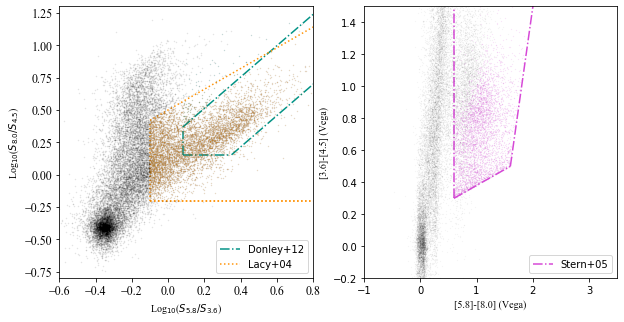

In [7]:
flux36 = 'f_ap_irac_i1'
flux45 = 'f_ap_irac_i2'
flux58 = 'f_ap_irac_i3'
flux80 = 'f_ap_irac_i4'
flux240 = 'f_mips_24'
# print(catalog[flux58][catalog[flux58] < 0])
never_nan = (np.nan_to_num(catalog[flux58], nan=-99) > 0) & (np.nan_to_num(catalog[flux80], nan=-99) > 0) #& (np.nan_to_num(catalog['zspec'], nan=-99) > 0)
fig, axs = sc.plot_wedge(catalog[never_nan], flux36, flux45, flux58, flux80, selection=['lacy05', 'stern05', 'donley12'])
selected_agn = sc.select_ir(catalog[never_nan], flux36, flux45, flux58, flux80, selection_cuts='lacy05')

In [8]:
print(np.sum(never_nan), np.sum(selected_agn))
ct_lacy = catalog[never_nan][selected_agn]

19816 6014


In [9]:
np.sum(ct_lacy[flux240] > 0) / 6014

1.0

We want to select our redshifts for each object. We prioritize spectroscopic redshifts, but default to photometric when specz are unavailable.

We also calculate the luminosity. L=4pi F^2, but remember we are using flux densitiy, so we need to convert and make units workout (hence, unit_conversion). The spectral index accounts for the shape of the SED. If the object is radiating differently in different wavelengths, the spectral index allows us to adjust the luminosity in order to account for this.

In [10]:
cosmo = af.setup_cosmology()
print('selected_agn:', len(ct_lacy))

ct_lacy = ct_lacy[(ct_lacy['z1_median'] > 0 ) | (ct_lacy['zspec'] > 0)]
# ct_lacy = ct_lacy[ct_lacy['z_eazy'] > 0]
print('selected agn with z:', len(ct_lacy))

# unit conversion: ujansky -> jansky: 1e-6
# jansky -> erg / s / cm**2 / Hz: 1e-23
# erg / s / Hz -> erg / s: nu = c/lambda = 3e8 / 3.6e-6
# unit_conversion = 1e-6 * 1e-23 * 3e8 / 3.6e-6 * (3.086e24)**2
wavelength = 5.8
unit_conversion = 3 / wavelength * 1e-15
# print(unit_conversion)

unbias_photoz = 0.0
z = np.array([row['zspec'] if row['zspec'] > 0 else row['z1_median'] - unbias_photoz for row in ct_lacy])
# z = np.array([row['z1_median'] - unbias_photoz for row in ct_lacy])
print(min(z))
z[z <= 0] = 0
# z = ct_lacy['z_eazy']

spectral_index = np.log10(ct_lacy[flux240].data/ct_lacy[flux58].data) / np.log10(24/5.8)
# spectral_index[spectral_index < -4] = -2
# spectral_index = np.array([0])
print(spectral_index.min(), spectral_index.max())

bolo_corr = 1

l = 4 * np.pi * cosmo.luminosity_distance(z).to(u.cm).value**2 * ct_lacy[flux58].data * unit_conversion * (1 + z)**(-1 + spectral_index) * bolo_corr

selected_agn: 6014
selected agn with z: 5914


/usr/local/lib/python3.8/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


0.0143
-3.4994921686418823 2.9282295326976766


Text(0, 0.5, 'k-correction')

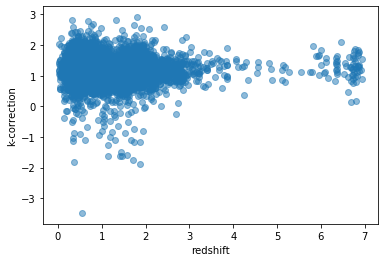

In [19]:
plt.scatter(z, spectral_index, alpha=0.5)
plt.xlabel('redshift')
plt.ylabel('k-correction')

In [11]:
z_sample_min = 0.5
z_sample_max = 4
l_sample_min = 3e42
l_sample_max = 3e46
num_bins_z = 10
num_bins_l = 15

# # compare to xray
# z_sample_min = 0.5
# z_sample_max = 4
# l_sample_min = 8e43
# l_sample_max = 3e47
# num_bins_z = 10
# num_bins_l = 15



We need to bin our samples by redshift and luminosity. We also only want samples that fall within the range of our bins.

In [12]:
# redshift range 
z_bins = np.logspace(np.log10(z_sample_min), np.log10(z_sample_max)+0.01, num=num_bins_z)
# print(z_bins)
l_bins = np.logspace(np.log10(l_sample_min), np.log10(l_sample_max), num=num_bins_l)

good_redshift_and_l_selected = (l_sample_min < l) & (l_sample_max > l) & (z_sample_min < z) & (z_sample_max > z)
l = l[good_redshift_and_l_selected]
z = z[good_redshift_and_l_selected]
print(min(l), max(l), min(z), max(z))
# print(len(z))

7.319597645207652e+42 2.507533722453583e+46 0.5001 3.87


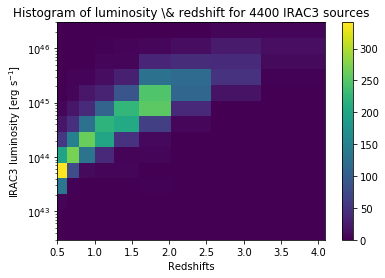

In [13]:

# print(len(z))
fig, ax = vmax.l_z_histo(l, z, l_bins, z_bins, band='IRAC3', unit=r'erg s$^{-1}$')

0.03974999999999995


/usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


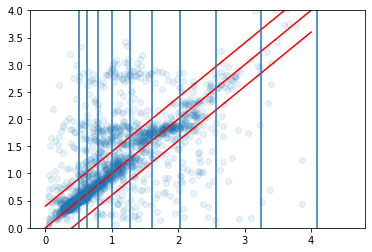

In [14]:
goodzs = (ct_lacy['z1_median'] > 0) & (ct_lacy['zspec'] > 0)
plt.scatter(ct_lacy['zspec'][goodzs], ct_lacy['z1_median'][goodzs], alpha=0.1)
ax = plt.gca()
ax.set_ylim(top=4, bottom=0)
ax.plot([0, 4],[0,4], color='r')
ax.plot([0, 4],[0.4,4.4], color='r')
ax.plot([0, 4],[-.4,3.6], color='r')
for zbin in z_bins:
    ax.axvline(zbin)
bias = np.median(ct_lacy['z1_median'][goodzs] - ct_lacy['zspec'][goodzs])
print(bias)

In [15]:
difs = ct_lacy['z1_median'][goodzs] - ct_lacy['zspec'][goodzs]


In [16]:
i = 2
inbin1 = (ct_lacy['zspec'][goodzs] > z_bins[i]) & (ct_lacy['zspec'][goodzs] < z_bins[i+1])

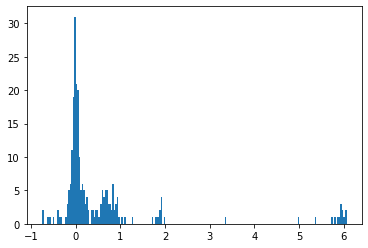

In [17]:
plt.hist(difs[inbin1], bins=200);

In [18]:
# import astropy as ap
# ap.visualization.hist(difs[inbin1], bins=100)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 35.333333  -4.5  
CRPIX : 9450.500101  9850.500106  
NAXIS : 4800  5000


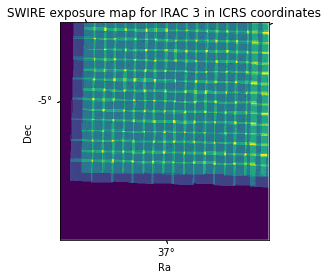

In [19]:
image_file = './data/swire_XMM_I3_tile_1_1_v4_cov.fits'
wcs, hdu = utils.load_wcs(image_file)
fig, ax = vmax.exposure_plot(wcs, hdu.data, survey='SWIRE', band='IRAC 3')

In [20]:
coveragefits = fits.open('./data/XMM-LSS_MOC.fits', memmap=True)
coveragefits[0].header

SIMPLE  =                    T / Written by MOC java API 4.4                    
BITPIX  =                    8                                                  
NAXIS   =                    0                                                  
EXTEND  =                    T                                                  

This is the footprint of the XMM-LSS field. Fortunately, coverage is pretty constant for IR across this field. For X-ray, the area looked at by XMM-Newton was flux-dependent. So when calculating the area on the sky, we had to take this into account.

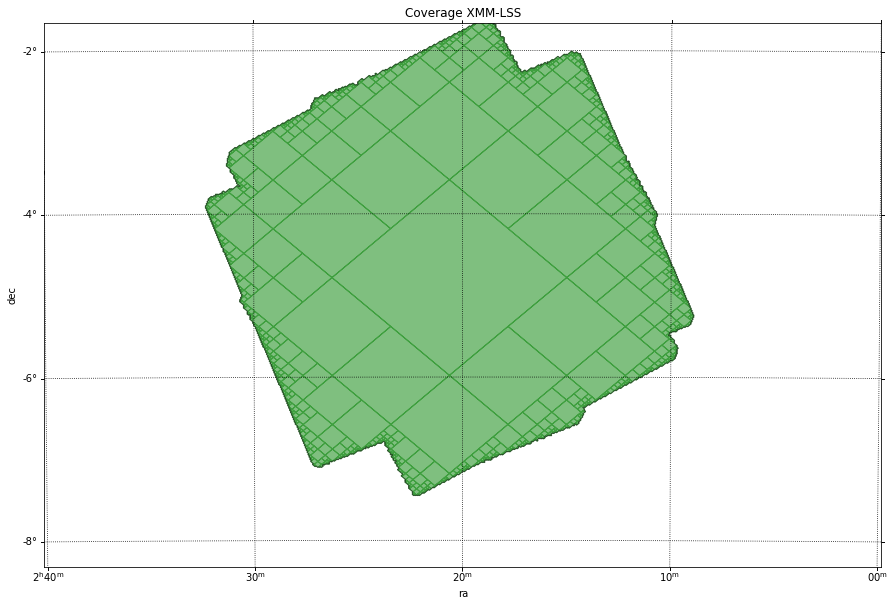

In [21]:
from mocpy import MOC, World2ScreenMPL
from astropy.coordinates import Angle, SkyCoord
import astropy.units as u
# Load a MOC
filename = './data/XMM-LSS_MOC.fits'
moc = MOC.from_fits(filename)
# Plot the MOC using matplotlib
import matplotlib.pyplot as plt
fig = plt.figure(111, figsize=(15, 10))
# Define a astropy WCS easily
with World2ScreenMPL(fig, 
        fov=10 * u.deg,
        center=SkyCoord(35, -5, unit='deg', frame='icrs'),
        coordsys="icrs",
        rotation=Angle(0, u.degree),
        projection="AIT") as wcs:
    ax = fig.add_subplot(1, 1, 1, projection=wcs)
    # Call fill with a matplotlib axe and the `~astropy.wcs.WCS` wcs object.
    moc.fill(ax=ax, wcs=wcs, alpha=0.5, fill=True, color="green")
    moc.border(ax=ax, wcs=wcs, alpha=0.5, color="black")
ax.set_xlabel('ra')
ax.set_ylabel('dec')
ax.set_title('Coverage XMM-LSS')
ax.grid(color="black", linestyle="dotted")


This is where the heavy lifting happens. We are calculating vmax. So this is the maximum volume that the object in question *could* occupy in the survey. So we have a given area (discussed briefly above) that is constant for IR and then depth is given by redshift. We also have a coverage correction that aims to address incompleteness of the sample by estimating what percent the *selected* AGN make up of the total number of AGN.

In [22]:

flux_limit = 43 * unit_conversion
# flux_limit = 3631 * 10**(23/-2.5) * 5.8e-6 / 3e8
print('computing zmax')
zmax = vmax.compute_zmax(l, z, cosmo, flux_limit, zspacing=0.5, jack_version=False)
zmin = np.array([0]*len(zmax))

# print(zmax)

print('calculating coverage correction')
full_fluxes = catalog[never_nan][flux58]
# print(len(full_fluxes), len(ct_lacy), len(good_redshift_and_l_selected))
coverage_correction = vmax.coverage_correction(full_fluxes, ct_lacy[flux58][good_redshift_and_l_selected])

# image_file = './data/chen2018-xmmlss-data-products-2018-06-08/xexp_merged.full.v01.fits'
# wcs, hdu = utils.load_wcs(image_file)
# cov_function = vmax.coverage_function(hdu.data, wcs, 3824, 2694, detector_area=36, photon_energy=7e-9)

field_coverage_area = 9.1

def cov_func(l, z): 
    flux = l / (4 * np.pi * cosmo.luminosity_distance(z).to(u.cm).value**2) / unit_conversion
# #     print(flux[0, 0], cov_function(flux[0, 0]))
    return field_coverage_area * coverage_correction(flux)

print('computing vmax vals')
vmax_vals = vmax.compute_binned_vmax_values(l, (z, zmin, zmax), l_bins, z_bins, cosmo, bin_z_bounds=False, coverage=cov_func)

computing zmax
bad zmax inference 215
this is probably due to an issue with the flux limit
zmax/zmin will default to zbin range
calculating coverage correction
computing vmax vals


In [23]:
 coverage_correction(np.logspace(-30, 0, num=50))

array([-0.17896143, -0.17896143, -0.17896143, -0.17896143, -0.17896143,
       -0.17896143, -0.17896143, -0.17896143, -0.17896143, -0.17896143,
       -0.17896143, -0.17896143, -0.17896143, -0.17896143, -0.17896143,
       -0.17896143, -0.17896143, -0.17896143, -0.17896143, -0.17896143,
       -0.17896143, -0.17896143, -0.17896143, -0.17896143, -0.17896143,
       -0.17896143, -0.17896143, -0.17896143, -0.17896143, -0.17896143,
       -0.17896143, -0.17896143, -0.17896143, -0.17896143, -0.17896143,
       -0.17896143, -0.17896143, -0.17896142, -0.17896142, -0.17896141,
       -0.17896138, -0.17896123, -0.17896061, -0.17895808, -0.17894773,
       -0.17890534, -0.17873174, -0.17802088, -0.17510999, -0.16319012])

In [24]:
zs = (z_bins[:-1]+z_bins[1:])/2
l_limits = 4 * np.pi * cosmo.luminosity_distance(zs).to(u.cm).value**2 * flux_limit * unit_conversion
print(l_limits)
lf_vals, lf_errs = vmax.compute_lf_values(l, z, vmax_vals, z_bins, l_bins)

[1.58066880e+28 2.78277224e+28 4.92606797e+28 8.74567420e+28
 1.55312411e+29 2.75244272e+29 4.85902012e+29 8.53464253e+29
 1.49055607e+30]


In [25]:
lit_data = {}
hz_convert = 5.8e-6 / 3e8 / bolo_corr
import importlib
importlib.reload(af)

lacy_ir_evol_params_central = {'A': 10**-4.75, 
                               'gamma1':1.07, 
                               'gamma2':2.48,
                               'Lstar': 10**31.92 / hz_convert,
                               'zref':2.5,
                               'k1':1.05,
                               'k2':-4.71,
                               'k3':-0.034
                              }
lacy_ir_evol_params_max = {'A': 10**-4.73, 
                               'gamma1':1.13, 
                               'gamma2':2.53,
                               'Lstar': 10**31.94 / hz_convert,
                               'zref':2.5,
                               'k1':1.08,
                               'k2':-4.58,
                               'k3':0.156
                              }
lacy_ir_evol_params_min = {'A': 10**-4.77, 
                               'gamma1':1.01, 
                               'gamma2':2.43,
                               'Lstar': 10**31.9 / hz_convert,
                               'zref':2.5,
                               'k1':1.02,
                               'k2':-4.84,
                               'k3':-0.224
                              }

center_zbins = (z_bins[1:] + z_bins[:-1]) / 2
ls = np.logspace(43, 46.2, num=50)
lacy_mid = af.IR_evol(ls, center_zbins, **lacy_ir_evol_params_central)
lacy_high = af.IR_evol(ls, center_zbins, **lacy_ir_evol_params_max)
lacy_low = af.IR_evol(ls, center_zbins, **lacy_ir_evol_params_min)
# print(lacy_mid[0])
lit_data['Lacy 2015'] = list(zip(lacy_mid, lacy_high, lacy_low))
# lacy_mid[1][:10]

# literature values...don't need to change
bolo_corr_xray = 1
aird_lade_params_central = {'A': 10**-4.53, 
                               'gamma1':0.62, 
                               'gamma2':3.01,
                               'Lstar': 10**44.77 * bolo_corr_xray,
                               'zc':0.75,
                               'p1':6.36,
                               'p2':-0.24,
                               'd':-0.19
                              }
aird_lade_params_min = {'A': 10**-4.46, 
                               'gamma1':0.6, 
                               'gamma2':2.9,
                               'Lstar': 10**44.71* bolo_corr_xray,
                               'zc':0.66,
                               'p1':5.96,
                               'p2':-0.51,
                               'd':-.21
                              }
aird_lade_params_max = {'A': 10**-4.6, 
                               'gamma1':0.64, 
                               'gamma2':3.12,
                               'Lstar':10**44.83* bolo_corr_xray,
                               'zc':0.84,
                               'p1':6.76,
                               'p2':0.03,
                               'd':-0.17
                              }

center_zbins = (z_bins[1:] + z_bins[:-1]) / 2
ls = np.logspace(43, 45.2, num=50) * bolo_corr_xray
aird_mid = af.LADE(ls, center_zbins, **aird_lade_params_central, no_k=True)
aird_high = af.LADE(ls, center_zbins, **aird_lade_params_max, no_k=True)
aird_low = af.LADE(ls, center_zbins, **aird_lade_params_min, no_k=True)
# print(ranalli_mid[0])
lit_data['Aird LADE'] = list(zip(aird_mid, aird_high, aird_low))

ranalli_lade_params_central = {'A': 10**-3.53, 
                               'gamma1':0.16, 
                               'gamma2':2.48,
                               'Lstar': 10**42.72* bolo_corr_xray,
                               'zc':1.72,
                               'p1':4.67,
                               'p2':-0.3,
                               'd':-0.29
                              }
ranalli_lade_params_min = {'A': 10**-3.65, 
                               'gamma1':0.09, 
                               'gamma2':2.37,
                               'Lstar': 10**42.65 * bolo_corr_xray,
                               'zc':1.53,
                               'p1':4.35,
                               'p2':-0.91,
                               'd':-0.31
                              }
ranalli_lade_params_max = {'A': 10**-3.48, 
                               'gamma1':0.23, 
                               'gamma2':2.6,
                               'Lstar':10**42.82 * bolo_corr_xray,
                               'zc':1.93,
                               'p1':5.0,
                               'p2':0.02,
                               'd':-0.26
                              }

center_zbins = (z_bins[1:] + z_bins[:-1]) / 2
ls = np.logspace(43, 45.2, num=50) * bolo_corr_xray
ranalli_mid = af.LADE(ls, center_zbins, **ranalli_lade_params_central)
ranalli_high = af.LADE(ls, center_zbins, **ranalli_lade_params_max)
ranalli_low = af.LADE(ls, center_zbins, **ranalli_lade_params_min)
# print(ranalli_mid[0])
lit_data['Ranalli LADE'] = list(zip(ranalli_mid, ranalli_high, ranalli_low))

In [26]:
# plot_files = ['./output/lf_91area_specz_kcorrected.npz']#, './output/lf_91area_bothz_unbiased.npz']
# labs = ['specz + k correction']#, 'specz + unbiased photoz']
plot_files = ['./output/lf_xray.npz']
labs = ['xray']
otherruns = {}
for lab, fil in zip(labs, plot_files):
    with np.load(fil) as infile:
        lfv = infile['lf_vals']
        lfe = infile['lf_errs']
    otherruns[lab] = [lfv, lfe]
    

This is the actual luminosity function. The orange points show the current calculation of the LF. Everything else is just bells and whistles for comparison.

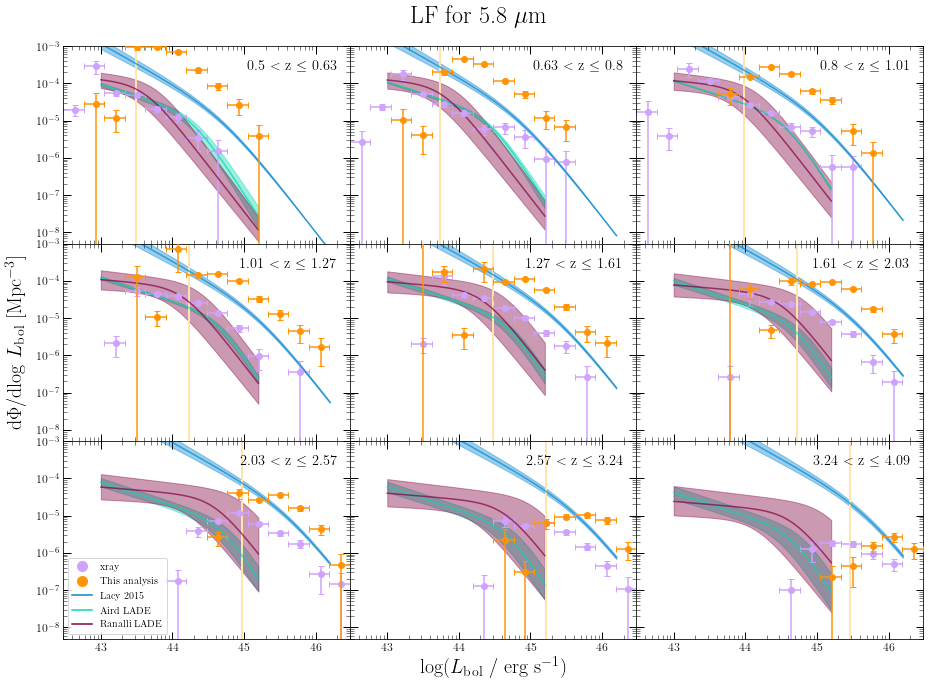

In [27]:
np.savez('./output/lf_91area_bothz_kcorrected.npz', lf_vals=lf_vals, lf_errs=lf_errs)

l_limits = 4 * np.pi * cosmo.luminosity_distance((z_bins[:-1]+z_bins[1:])/2)**2 * flux_limit/(u.cm**2)
l_limits = l_limits.decompose()
fig, axs, big_ax = vmax.plot_lf_vmax(lf_vals, lf_errs, z_bins, l_bins, \
                                     lum_limits=l_limits, compare_to_others=lit_data, \
                                     other_runs=otherruns, title=r'LF for 5.8 $\mu$m', \
                                     outfile='./output/ir_lf.png', lum_sublabel=r'_{{\mathrm{bol}}}')

In [28]:
vmax_vals[vmax_vals < 0]

array([], dtype=float64)

/usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


nan


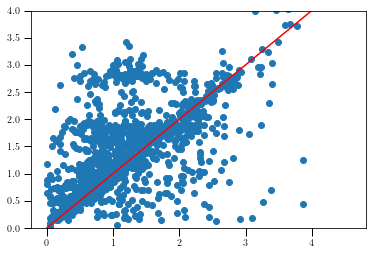

In [29]:
goodzs = (ct_lacy['z1_median'] > 0)
plt.scatter(ct_lacy['zspec'][goodzs], ct_lacy['z1_median'][goodzs])
ax = plt.gca()
ax.set_ylim(top=4, bottom=0)
ax.plot([0, 4],[0,4], color='r')
bias = np.median(ct_lacy['z1_median'][goodzs] - ct_lacy['zspec'][goodzs])
print(bias)

In [30]:
from astropy import cosmology

In [31]:
greene = cosmology.LambdaCDM(H0=71, Om0=0.27, Ode0=0.75)
farrah = cosmology.LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
medling = cosmology.LambdaCDM(H0=70, Om0=0.28, Ode0=0.72)

In [32]:
z=1
farrah.luminosity_distance(z)**2/greene.luminosity_distance(z)**2, farrah.luminosity_distance(z)**2/medling.luminosity_distance(z)**2

(<Quantity 0.98335027>, <Quantity 0.97612978>)